In [1]:
from src.dataset_segmented import AnimeAudioDataset
import torch
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn.ensemble import AdaBoostClassifier
import pickle

#### IMPORTANT: Remember the features and other data are not normalized. Check dataset_segmented.

# Load data

In [2]:
data = AnimeAudioDataset()

# Visualize all data points

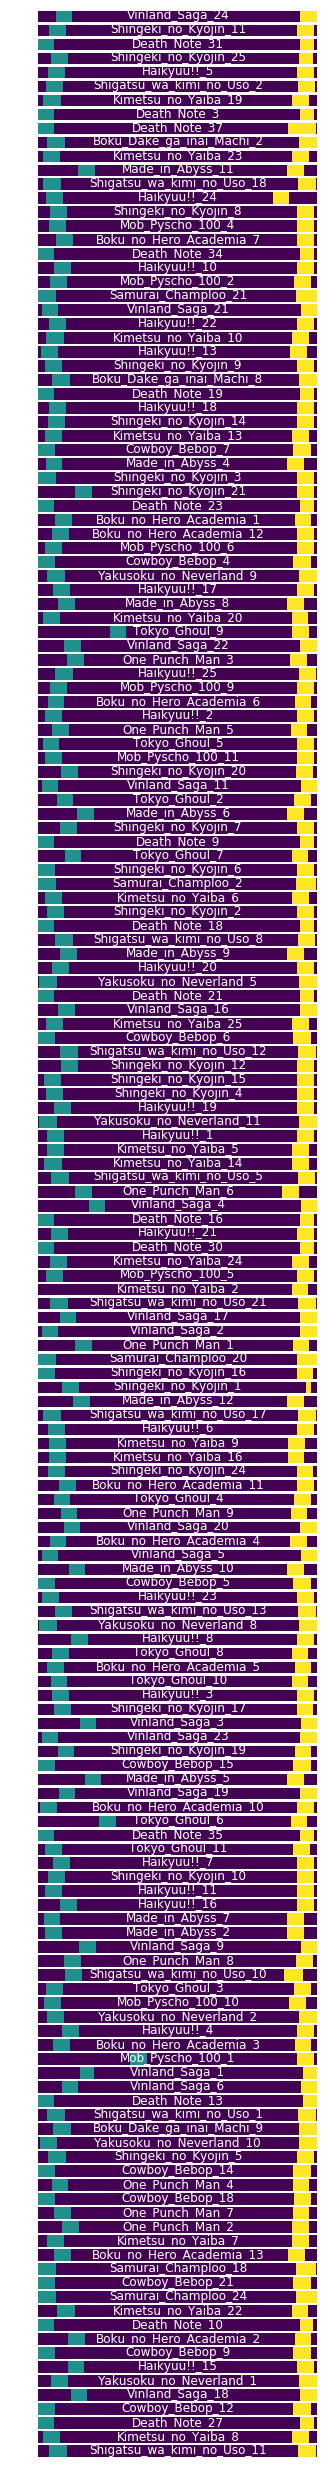

In [22]:
import matplotlib.pyplot as plt

width=5
height=45
plt.rcParams["figure.figsize"] = (width,height)
plt.rcParams['text.color'] = 'white'
# plt.axis('off')
axes=[]
fig=plt.figure()

i=0
for a in data.labels96:
    axes.append( fig.add_subplot(len(data.labels96),1, i+1) )
    subplot_title=(a)
    axes[-1].set_title(subplot_title, y=-.2)  
    plt.imshow(data.labels96[a].cpu().numpy().reshape((1,-1)), aspect='auto')
    plt.axis('off')
    i += 1   
plt.show()

# Adaboost

The goal was to use adaboost to be a benchmark for further ml tactics. Turns out, adaboost works pretty well

In [4]:
valid_len = len(data) // 5
train_len = len(data) - valid_len
valid, train = torch.utils.data.random_split(data, [valid_len, train_len])

In [5]:
X_train = [t[0].cpu().numpy() for t in train]
y_train = [t[1].cpu().numpy() for t in train]

X_valid = [t[0].cpu().numpy() for t in valid]
y_valid = [t[1].cpu().numpy() for t in valid]

## Training

In [6]:
def unroll(X):
    rX = []
    for x in X:
        for smolx in x:
            rX.append(smolx)
    return rX

In [7]:
X_train = unroll(X_train)
y_train = unroll(y_train)

X_valid = unroll(X_valid)
y_valid = unroll(y_valid)

In [8]:
print(np.array(X_train).shape)
print(np.array(y_train).shape)

(210105, 128)
(210105,)


In [9]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

### training acc

In [10]:
# train acc
train_acc = clf.score(X_train, y_train)
valid_acc = clf.score(X_valid, y_valid)
print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {valid_acc}")

Training Accuracy: 0.9352752195330906
Validation Accuracy: 0.9273474982864977


## example of output

In [11]:
# params
plt.rcParams["figure.figsize"] = (20,1)

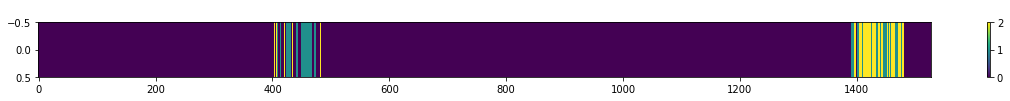

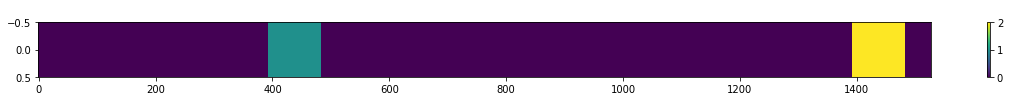

In [12]:
fn = 'Tokyo_Ghoul_9'
y = clf.predict(data.features[fn].cpu().numpy())

plt.title('predict')
plt.imshow(y.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

plt.title('actual')
plt.imshow(data.labels96[fn].cpu().numpy().reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

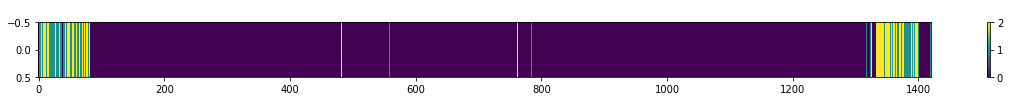

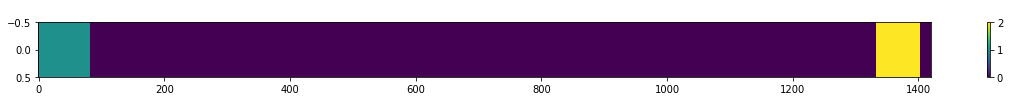

In [13]:
fn = 'Death_Note_3'
y = clf.predict(data.features[fn].cpu().numpy())

plt.title('predict')
plt.imshow(y.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

plt.title('actual')
plt.imshow(data.labels96[fn].cpu().numpy().reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

It is actually surprising that the classifier can tell between outros and intros. Upon listening, this is probably because outros tend to be softer and slower while intros are more aggressive. This is supported by the death note 21 wav file- Death Note's intro and outtro are more aggressive, so the classifier thinks that both are intros. This could be solved with a simple time test of whether the section is in the first or secound half of the episode. However, I think this should be done separate from adaboost (meaning afterward) b/c the time metric would be too strong for decision forests

# outro/intro merge

with this is mind, let's try a scoring system where we do not differentiate between intro and outtro
 - test where we train with both labels but then turn them into one label in postprocess
 - test with train with only one label

In [14]:
def to_one(arr):
    return (np.array(arr) >= 1).astype(int).tolist()

In [15]:
y_train_one = to_one(y_train)
y_valid_one = to_one(y_valid)

In [16]:
clf.fit(X_train, y_train_one)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [17]:
# train acc
train_acc = clf.score(X_train, y_train_one)
valid_acc = clf.score(X_valid, y_valid_one)
print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {valid_acc}")

Training Accuracy: 0.969567597153804
Validation Accuracy: 0.9623791028862996


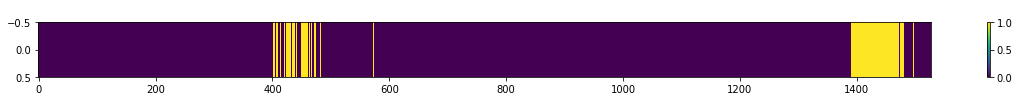

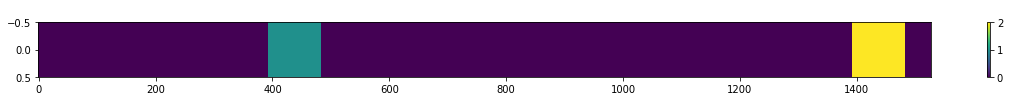

In [18]:
fn = 'Tokyo_Ghoul_9'
y = clf.predict(data.features[fn].cpu().numpy())

plt.title('predict')
plt.imshow(y.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

plt.title('actual')
plt.imshow(data.labels96[fn].cpu().numpy().reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

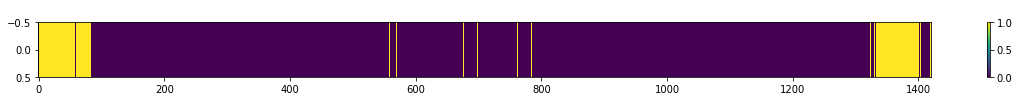

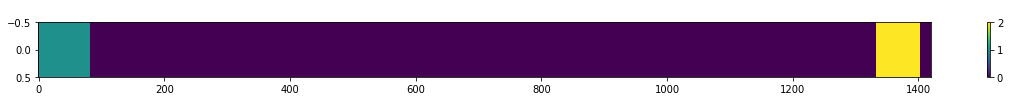

In [19]:
fn = 'Death_Note_3'
y = clf.predict(data.features[fn].cpu().numpy())

plt.title('predict')
plt.imshow(y.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

plt.title('actual')
plt.imshow(data.labels96[fn].cpu().numpy().reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

In [20]:
# save model
filename = 'adaboost.sav'
pickle.dump(clf, open(filename, 'wb'))

# load model
# filename = 'adaboost.sav'
# clf = pickle.load(open(filename, 'rb'))

# Sliding window

This adaboost classifier works surprisingly well, but can use some improvements. Perhaps a sliding pooling window using averaging or voting.

In [61]:
def sliding_avg(arr, window_len):
    start = 0
    end = window_len
    wsum = sum(arr[start:end])
    wsum_arr = []
    wsum_arr.append(wsum/window_len)
    while end != len(arr):
        wsum -= arr[start]
        wsum += arr[end]
        start += 1
        end += 1
        wsum_arr.append(wsum/window_len)
    return wsum_arr

In [62]:
filename = 'adaboost.sav'
clf = pickle.load(open(filename, 'rb'))

In [63]:
# benchmark
sklearn.metrics.accuracy_score(y_pred_one, y_one)

0.9686771028814405

In [64]:
len(y_one)

210485

Let's calculate our new predictions after using a sliding average

In [65]:
def avg_new(arr, window_len):
    # one function to do buffering, averaging, and rounding all
    assert window_len%2 == 1 # please use odd numbers
    buffer= [0]*(window_len//2)
    buffered = np.concatenate((buffer,arr,buffer))
    return np.round(sliding_avg(buffered, window_len))

In [66]:
# size 11 window is arbitrary
y_pred_one_new = avg_new(y_pred_one, 11)

In [67]:
sklearn.metrics.accuracy_score(y_pred_one_new, y_one)

0.9843409269069054

This is indeed higher. I have to wonder if there is a problem because the songs are stacked directly on each other with no buffer. This will be time consuming to test and I will leave it to later because I don't think that the stacking without buffer is negatively affecting our predictions much.

Let's see some examples

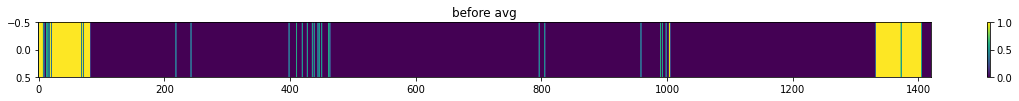

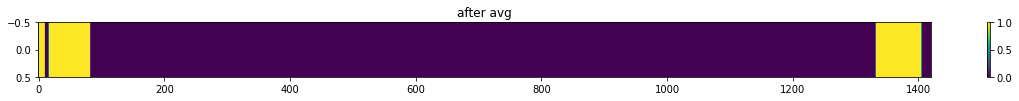

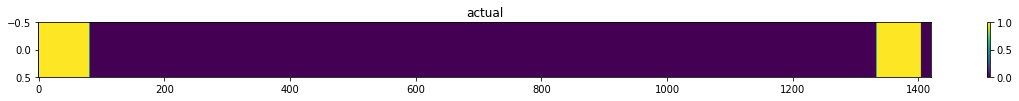

score before avg:  0.9753694581280788
score after avg:  0.9936664320900774


In [68]:
fn = 'Death_Note_21'
y = clf.predict(data.features[fn].cpu().numpy())
y = to_one(y)
a = to_one(data.labels96[fn].cpu().numpy())

plt.title('before avg')
plt.imshow(y.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

y_new = avg_new(y,11)

plt.title('after avg')
plt.imshow(y_new.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

plt.title('actual')
plt.imshow(a.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

print('score before avg: ',sklearn.metrics.accuracy_score(y, a))
print('score after avg: ',sklearn.metrics.accuracy_score(y_new, a))

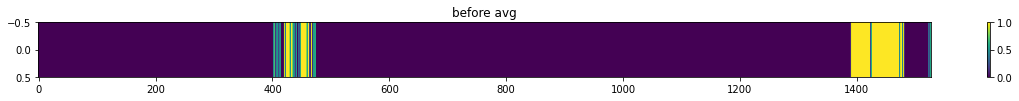

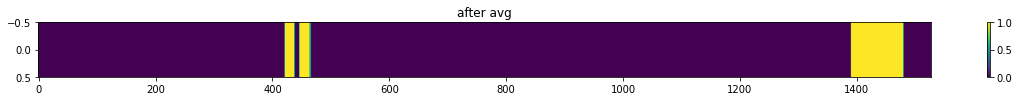

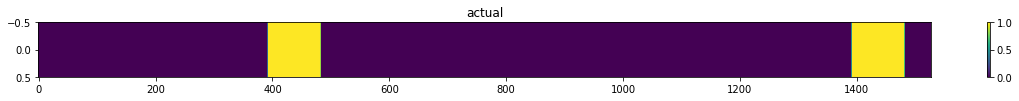

score before avg:  0.962696335078534
score after avg:  0.9620418848167539


In [69]:
fn = 'Tokyo_Ghoul_9'
y = clf.predict(data.features[fn].cpu().numpy())
y = to_one(y)
a = to_one(data.labels96[fn].cpu().numpy())

plt.title('before avg')
plt.imshow(y.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

y_new = avg_new(y,11)

plt.title('after avg')
plt.imshow(y_new.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

plt.title('actual')
plt.imshow(a.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

print('score before avg: ',sklearn.metrics.accuracy_score(y, a))
print('score after avg: ',sklearn.metrics.accuracy_score(y_new, a))

Well obviously 11 may not be the best window. It might also be best to change the rounding algorithm to be more leniant

In [72]:
def avg_new(arr, window_len, cutoff):
    # one function to do buffering, averaging, and rounding all
    assert window_len%2 == 1 # please use odd numbers
    buffer= [0]*(window_len//2)
    buffered = np.concatenate((buffer,arr,buffer))
    avg = sliding_avg(buffered, window_len)
    return np.array([1 if i>cutoff else 0 for i in avg])

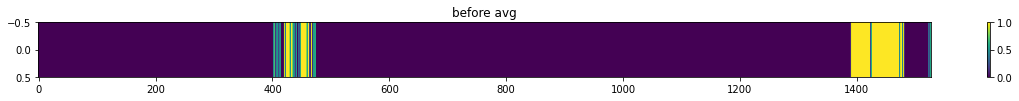

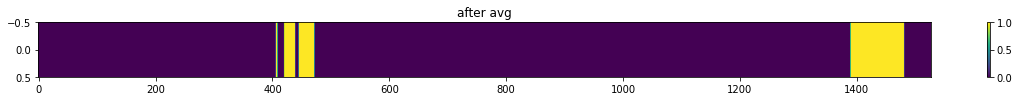

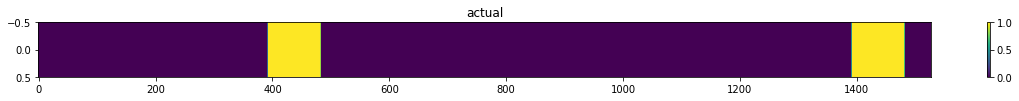

score before avg:  0.962696335078534
score after avg:  0.9705497382198953


In [80]:
fn = 'Tokyo_Ghoul_9'
y = clf.predict(data.features[fn].cpu().numpy())
y = to_one(y)
a = to_one(data.labels96[fn].cpu().numpy())

plt.title('before avg')
plt.imshow(y.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

y_new = avg_new(y,11,.4)

plt.title('after avg')
plt.imshow(y_new.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

plt.title('actual')
plt.imshow(a.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

print('score before avg: ',sklearn.metrics.accuracy_score(y, a))
print('score after avg: ',sklearn.metrics.accuracy_score(y_new, a))

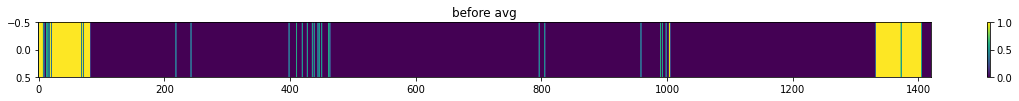

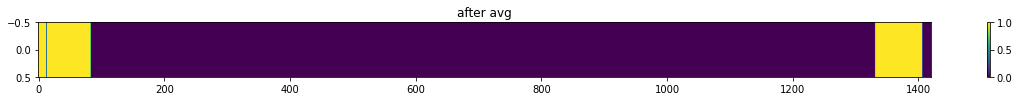

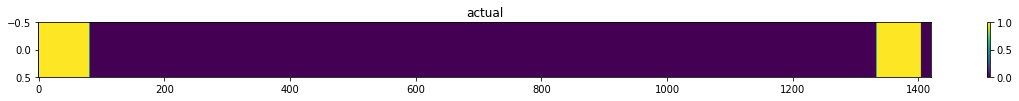

score before avg:  0.9753694581280788
score after avg:  0.9943701618578465


In [81]:
fn = 'Death_Note_21'
y = clf.predict(data.features[fn].cpu().numpy())
y = to_one(y)
a = to_one(data.labels96[fn].cpu().numpy())

plt.title('before avg')
plt.imshow(y.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

y_new = avg_new(y,11,.4)

plt.title('after avg')
plt.imshow(y_new.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

plt.title('actual')
plt.imshow(a.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

print('score before avg: ',sklearn.metrics.accuracy_score(y, a))
print('score after avg: ',sklearn.metrics.accuracy_score(y_new, a))

After some testing, it seems that a .3-.4 ish for cutoff is a good value that isn't too aggressive at cutting off noise and not too lenient to misunderstand noise as intro/outro

In [84]:
y_pred_one_new = avg_new(y_pred_one, 11, .3)
sklearn.metrics.accuracy_score(y_pred_one_new, y_one)

0.9863553222319881

In [87]:
y_pred_one_new = avg_new(y_pred_one, 11, .4)
sklearn.metrics.accuracy_score(y_pred_one_new, y_one)

0.9866261253771053

In [88]:
y_pred_one_new = avg_new(y_pred_one, 11, .5)
sklearn.metrics.accuracy_score(y_pred_one_new, y_one)

0.9843409269069054